# Laboratorio 2: Segmentación Simple por Color
## Una Aplicación Práctica del Procesamiento Digital de Imágenes

### Objetivos del Laboratorio
Al finalizar este laboratorio, los estudiantes podrán:
1. Comprender qué es la segmentación de imágenes y por qué es importante
2. Aplicar conceptos previos (espacios de color, cuantización) en un problema real
3. Implementar técnicas básicas de segmentación por color
4. Analizar y procesar los resultados de la segmentación

### ¿Por qué es importante la segmentación?
La segmentación de imágenes es el proceso de dividir una imagen en regiones significativas. Es fundamental en:
- **Medicina**: Detección de tumores en radiografías
- **Agricultura**: Identificación de cultivos y plagas
- **Industria**: Control de calidad en productos
- **Seguridad**: Reconocimiento de objetos sospechosos
- **Transporte**: Detección de señales de tráfico

En este laboratorio aprenderemos a segmentar objetos basándose en su color, conectando todos los conceptos que hemos visto anteriormente.

## Sección 1: Preparación del Entorno y Datos

### Importación de Bibliotecas
Utilizaremos las mismas bibliotecas de los laboratorios anteriores. Recuerda que cada una tiene un propósito específico:

In [ ]:
# Biblioteca para operaciones numéricas con matrices (recordar Lab 1)
import numpy as np

# OpenCV para lectura de imágenes (usa formato BGR por defecto)
from cv2 import imread, inRange, findContours, RETR_EXTERNAL, CHAIN_APPROX_SIMPLE
from google.colab.patches import cv2_imshow

# Matplotlib para visualización (usa formato RGB)
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Para crear widgets interactivos (opcional)
from ipywidgets import interact, IntSlider

### Funciones Auxiliares
Definimos funciones que nos ayudarán a analizar nuestras imágenes:

In [ ]:
def informacion_imagen(imagen):
    """
    Muestra información básica de una imagen.
    Esta función nos ayuda a entender las características de nuestra imagen.
    """
    print(f'Dimensiones (alto, ancho, canales): {imagen.shape}')
    print(f'Valor máximo de píxel: {np.max(imagen)}')
    print(f'Valor mínimo de píxel: {np.min(imagen)}')
    print(f'Tipo de datos: {imagen.dtype}')

def mostrar_histograma_canal(canal, titulo="Histograma", color='blue'):
    """
    Muestra el histograma de un canal de color específico.
    El histograma nos ayuda a entender la distribución de intensidades.
    """
    # Usamos numpy para calcular el histograma (más eficiente que loops manuales)
    histograma, bins = np.histogram(canal.flatten(), bins=256, range=[0, 256])

    plt.figure(figsize=(8, 4))
    plt.plot(bins[:-1], histograma, color=color, linewidth=2)
    plt.title(titulo)
    plt.xlabel('Intensidad del píxel (0-255)')
    plt.ylabel('Frecuencia (número de píxeles)')
    plt.grid(True, alpha=0.3)
    plt.show()

def mostrar_imagenes_lado_a_lado(img1, img2, titulo1="Imagen 1", titulo2="Imagen 2"):
    """
    Muestra dos imágenes una al lado de la otra para comparación.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].imshow(img1)
    axes[0].set_title(titulo1)
    axes[0].axis('off')

    axes[1].imshow(img2, cmap='gray' if len(img2.shape) == 2 else None)
    axes[1].set_title(titulo2)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

### Descarga y Preparación de la Imagen
Trabajaremos con una imagen que contiene flores de diferentes colores. Esto nos permitirá practicar la segmentación por color.

In [ ]:
# Descargamos la imagen de ejemplo
!wget -q https://www.dropbox.com/s/jetlnfihles3g7k/flowers.jpg
print("Imagen descargada exitosamente")

Imagen descargada exitosamente


## Sección 2: Carga y Análisis Inicial de la Imagen

### Recordatorio: Espacios de Color BGR vs RGB
Recuerda que OpenCV lee imágenes en formato BGR (Azul-Verde-Rojo), mientras que matplotlib las muestra en RGB (Rojo-Verde-Azul). Esta diferencia es crucial para la segmentación por color.

=== INFORMACIÓN DE LA IMAGEN ===
Dimensiones (alto, ancho, canales): (512, 512, 3)
Valor máximo de píxel: 255
Valor mínimo de píxel: 0
Tipo de datos: uint8

=== VISUALIZACIÓN EN FORMATO BGR (OpenCV) ===


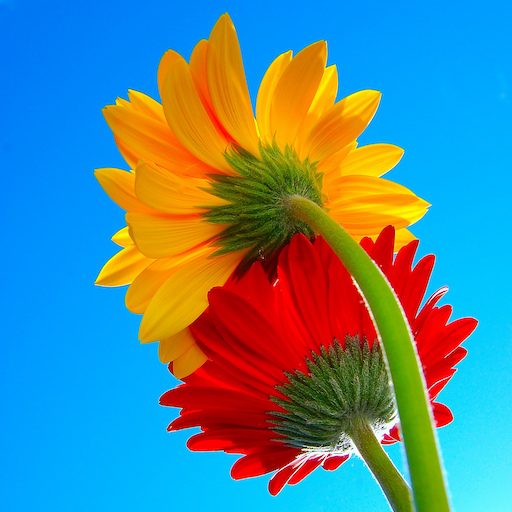

In [ ]:
# Cargamos la imagen usando OpenCV (formato BGR)
imagen_bgr = imread('flowers.jpg')

print("=== INFORMACIÓN DE LA IMAGEN ===")
informacion_imagen(imagen_bgr)

print("\n=== VISUALIZACIÓN EN FORMATO BGR (OpenCV) ===")
cv2_imshow(imagen_bgr)

=== VISUALIZACIÓN EN FORMATO RGB (matplotlib) ===


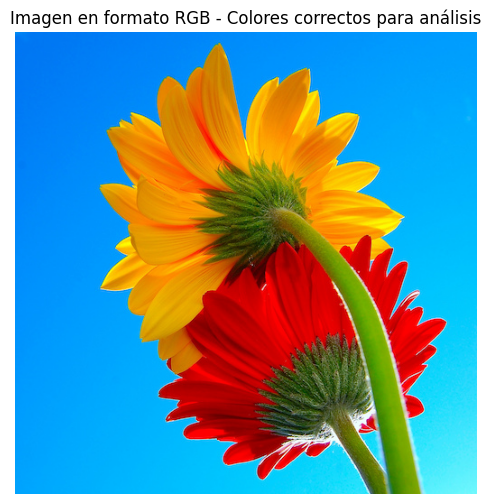


¿Notas la diferencia en los colores? Esta conversión es fundamental para segmentación.


In [ ]:
# Convertimos BGR a RGB para visualización correcta en matplotlib
# Método 1: Intercambio manual de canales (como en laboratorios anteriores)
imagen_rgb = imagen_bgr[:, :, [2, 1, 0]]  # Intercambiamos canal 0 (B) con canal 2 (R)

print("=== VISUALIZACIÓN EN FORMATO RGB (matplotlib) ===")
plt.figure(figsize=(10, 6))
plt.imshow(imagen_rgb)
plt.title('Imagen en formato RGB - Colores correctos para análisis')
plt.axis('off')
plt.show()

# Verificamos que la conversión sea correcta
print("\n¿Notas la diferencia en los colores? Esta conversión es fundamental para segmentación.")

## Sección 3: Análisis de Canales de Color

### ¿Por qué separar canales?
La separación de canales nos permite:
1. Entender qué colores predominan en cada región
2. Identificar los mejores umbrales para segmentación
3. Aplicar los conceptos de cuantización vistos anteriormente

=== CANALES SEPARADOS ===
Cada canal tiene dimensiones: (512, 512)
Rango de valores en canal rojo: 0 - 255


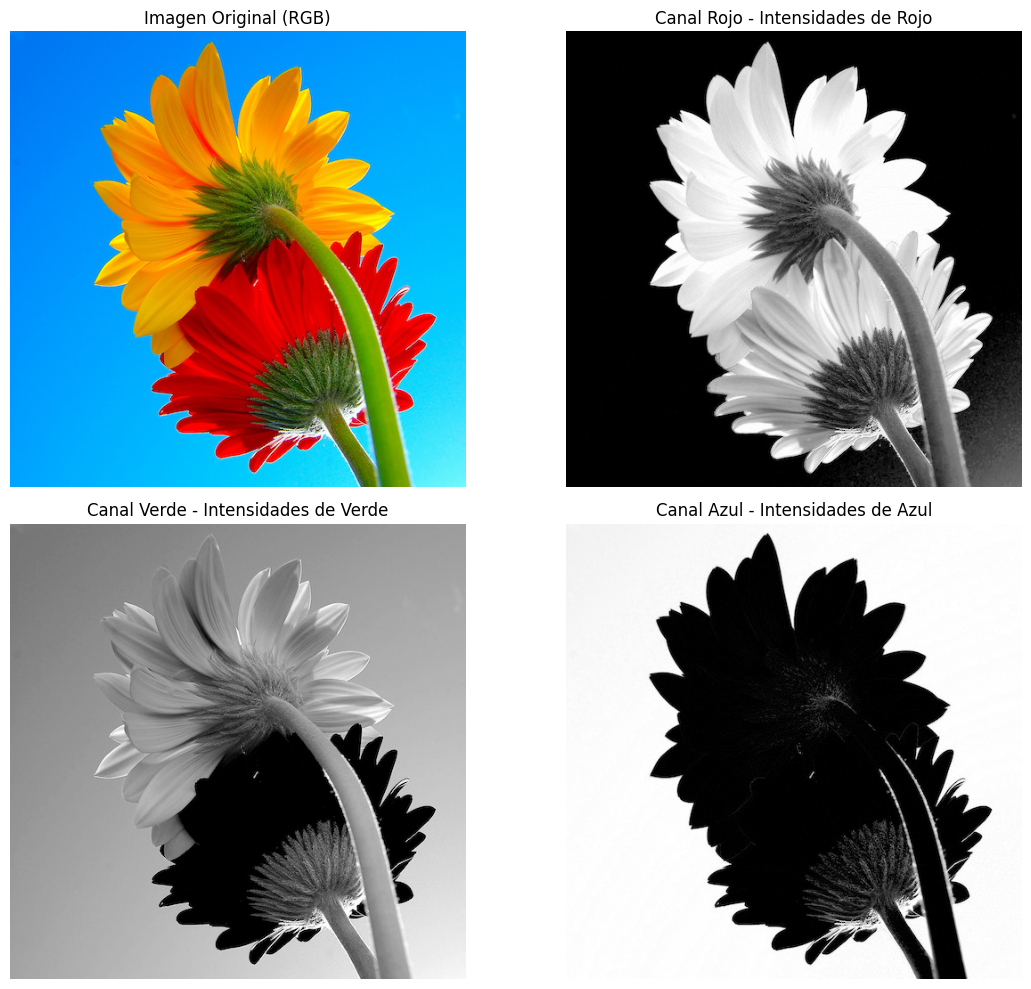


Observa: Las flores rojas aparecen más brillantes en el canal rojo.
Esto nos da pistas sobre qué umbrales usar para segmentación.


In [ ]:
# Separamos los canales de color RGB
canal_rojo = imagen_rgb[:, :, 0]    # Canal 0: intensidades de rojo
canal_verde = imagen_rgb[:, :, 1]   # Canal 1: intensidades de verde
canal_azul = imagen_rgb[:, :, 2]    # Canal 2: intensidades de azul

print("=== CANALES SEPARADOS ===")
print(f"Cada canal tiene dimensiones: {canal_rojo.shape}")
print(f"Rango de valores en canal rojo: {canal_rojo.min()} - {canal_rojo.max()}")

# Visualizamos los tres canales por separado
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Imagen original
axes[0, 0].imshow(imagen_rgb)
axes[0, 0].set_title('Imagen Original (RGB)')
axes[0, 0].axis('off')

# Canal Rojo
axes[0, 1].imshow(canal_rojo, cmap='gray')
axes[0, 1].set_title('Canal Rojo - Intensidades de Rojo')
axes[0, 1].axis('off')

# Canal Verde
axes[1, 0].imshow(canal_verde, cmap='gray')
axes[1, 0].set_title('Canal Verde - Intensidades de Verde')
axes[1, 0].axis('off')

# Canal Azul
axes[1, 1].imshow(canal_azul, cmap='gray')
axes[1, 1].set_title('Canal Azul - Intensidades de Azul')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("\nObserva: Las flores rojas aparecen más brillantes en el canal rojo.")
print("Esto nos da pistas sobre qué umbrales usar para segmentación.")

### Análisis de Histogramas por Canal
Los histogramas nos ayudan a entender la distribución de intensidades en cada canal. Esto es crucial para elegir umbrales apropiados.

=== HISTOGRAMAS POR CANAL ===
Estos histogramas nos ayudan a elegir umbrales para segmentación



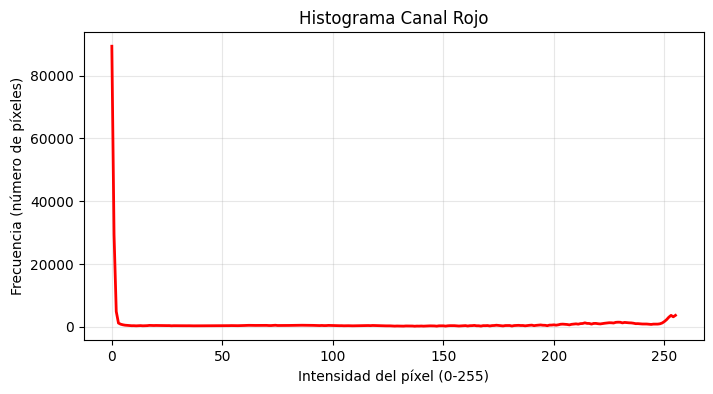

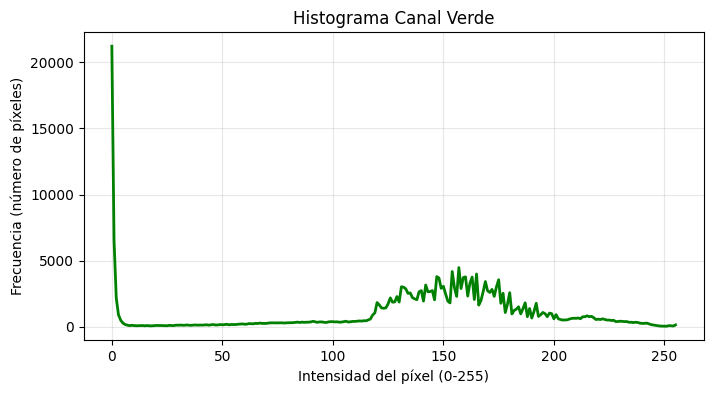

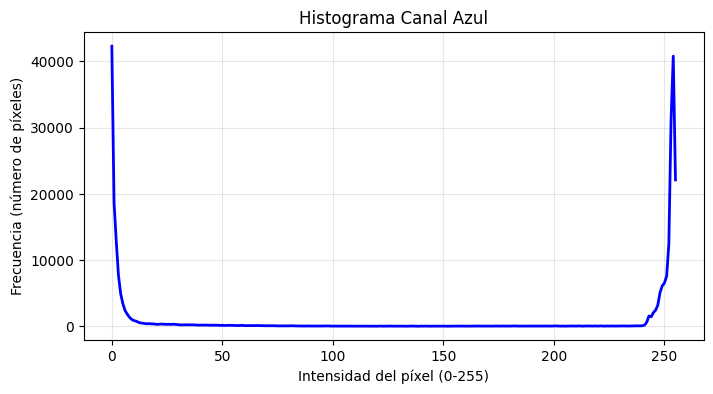

INTERPRETACIÓN:
- Picos altos indican intensidades muy comunes en la imagen
- Para segmentar flores rojas, buscaremos regiones con:
  * ALTO valor en canal rojo (>150)
  * BAJO valor en canales verde y azul (<50)


In [ ]:
# Mostramos histogramas de cada canal
print("=== HISTOGRAMAS POR CANAL ===")
print("Estos histogramas nos ayudan a elegir umbrales para segmentación\n")

mostrar_histograma_canal(canal_rojo, "Histograma Canal Rojo", 'red')
mostrar_histograma_canal(canal_verde, "Histograma Canal Verde", 'green')
mostrar_histograma_canal(canal_azul, "Histograma Canal Azul", 'blue')

print("INTERPRETACIÓN:")
print("- Picos altos indican intensidades muy comunes en la imagen")
print("- Para segmentar flores rojas, buscaremos regiones con:")
print("  * ALTO valor en canal rojo (>150)")
print("  * BAJO valor en canales verde y azul (<50)")

## Sección 4: Segmentación por Color - Teoría y Práctica

### ¿Qué es la Segmentación por Color?
La segmentación por color consiste en:
1. **Definir rangos de color**: Establecer umbrales mínimos y máximos para cada canal
2. **Crear máscaras binarias**: Píxeles que cumplen el criterio = 1, otros = 0
3. **Combinar condiciones**: Usar operaciones lógicas (AND, OR) entre canales

### Eligiendo Umbrales
Basándose en los histogramas, elegiremos umbrales para segmentar las flores rojas:

In [ ]:
# Definimos umbrales basados en el análisis de histogramas
print("=== DEFINICIÓN DE UMBRALES ===")
print("Para flores rojas buscamos:")

# Umbrales para flores rojas
umbral_rojo_min = 150   # Valor mínimo en canal rojo
umbral_verde_max = 50   # Valor máximo en canal verde
umbral_azul_max = 50    # Valor máximo en canal azul

print(f"- Canal ROJO >= {umbral_rojo_min} (flores rojas tienen mucho rojo)")
print(f"- Canal VERDE <= {umbral_verde_max} (flores rojas tienen poco verde)")
print(f"- Canal AZUL <= {umbral_azul_max} (flores rojas tienen poco azul)")

# Creamos máscaras individuales para cada condición
mascara_rojo = canal_rojo >= umbral_rojo_min
mascara_verde = canal_verde <= umbral_verde_max
mascara_azul = canal_azul <= umbral_azul_max

print(f"\n=== ESTADÍSTICAS DE MÁSCARAS INDIVIDUALES ===")
print(f"Píxeles con mucho rojo: {np.sum(mascara_rojo)} de {mascara_rojo.size}")
print(f"Píxeles con poco verde: {np.sum(mascara_verde)} de {mascara_verde.size}")
print(f"Píxeles con poco azul: {np.sum(mascara_azul)} de {mascara_azul.size}")

=== DEFINICIÓN DE UMBRALES ===
Para flores rojas buscamos:
- Canal ROJO >= 150 (flores rojas tienen mucho rojo)
- Canal VERDE <= 50 (flores rojas tienen poco verde)
- Canal AZUL <= 50 (flores rojas tienen poco azul)

=== ESTADÍSTICAS DE MÁSCARAS INDIVIDUALES ===
Píxeles con mucho rojo: 85694 de 262144
Píxeles con poco verde: 36848 de 262144
Píxeles con poco azul: 108974 de 262144


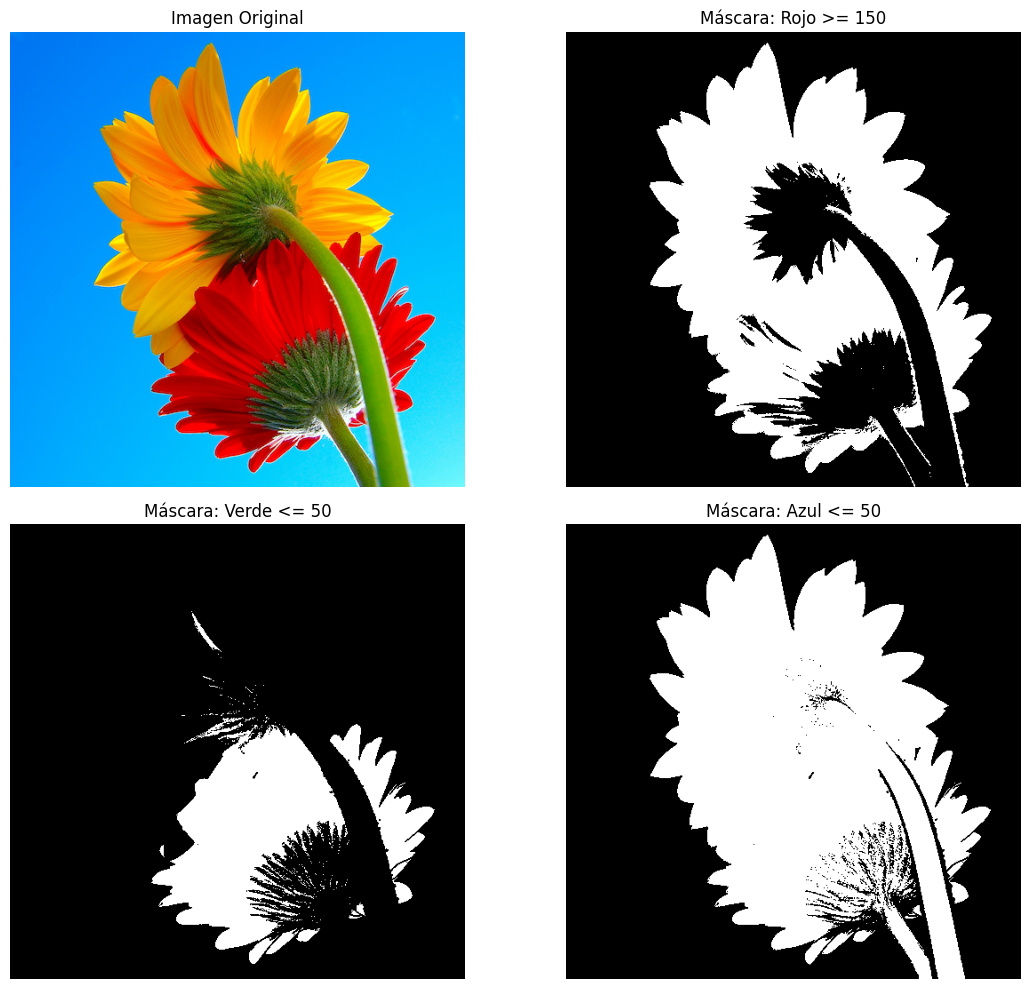

En las máscaras: BLANCO = píxeles que cumplen la condición, NEGRO = no cumplen


In [ ]:
# Visualizamos las máscaras individuales
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].imshow(imagen_rgb)
axes[0, 0].set_title('Imagen Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(mascara_rojo, cmap='gray')
axes[0, 1].set_title(f'Máscara: Rojo >= {umbral_rojo_min}')
axes[0, 1].axis('off')

axes[1, 0].imshow(mascara_verde, cmap='gray')
axes[1, 0].set_title(f'Máscara: Verde <= {umbral_verde_max}')
axes[1, 0].axis('off')

axes[1, 1].imshow(mascara_azul, cmap='gray')
axes[1, 1].set_title(f'Máscara: Azul <= {umbral_azul_max}')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("En las máscaras: BLANCO = píxeles que cumplen la condición, NEGRO = no cumplen")

### Combinando Máscaras con Operaciones Lógicas
Para que un píxel sea considerado "flor roja", debe cumplir TODAS las condiciones simultáneamente. Usamos la operación lógica AND:

In [ ]:
# Combinamos las máscaras usando operación AND lógica
# Un píxel es "flor roja" si cumple TODAS las condiciones
mascara_final = np.logical_and(
    np.logical_and(mascara_rojo, mascara_verde),
    mascara_azul
)

# Método alternativo más eficiente usando OpenCV
# Definimos rangos inferior y superior para cada canal
limite_inferior = np.array([umbral_rojo_min, 0, 0])  # [R_min, G_min, B_min]
limite_superior = np.array([255, umbral_verde_max, umbral_azul_max])  # [R_max, G_max, B_max]

# cv2.inRange es más eficiente que operaciones manuales
mascara_opencv = inRange(imagen_rgb, limite_inferior, limite_superior)

print("=== RESULTADOS DE SEGMENTACIÓN ===")
print(f"Píxeles identificados como flores rojas: {np.sum(mascara_final)}")
print(f"Porcentaje de la imagen: {100 * np.sum(mascara_final) / mascara_final.size:.2f}%")

# Comparamos ambos métodos
print(f"\nVerificación: Ambos métodos dan el mismo resultado: {np.array_equal(mascara_final, mascara_opencv > 0)}")

=== RESULTADOS DE SEGMENTACIÓN ===
Píxeles identificados como flores rojas: 30476
Porcentaje de la imagen: 11.63%

Verificación: Ambos métodos dan el mismo resultado: True


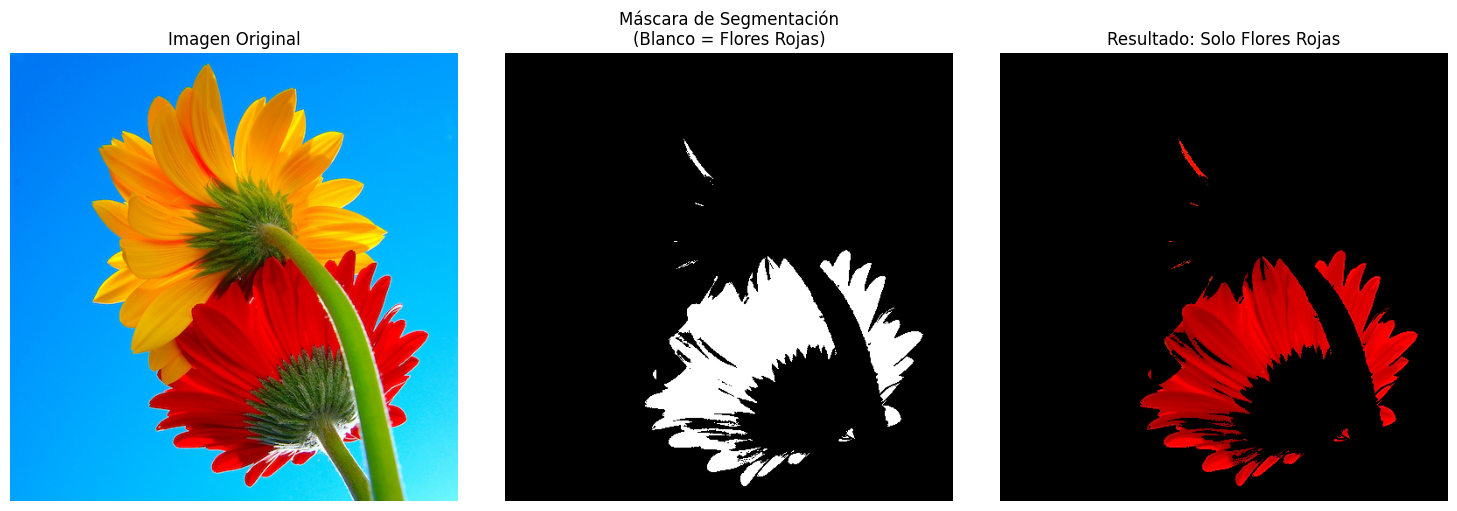


EXCELENTE: La segmentación ha identificado exitosamente las flores rojas!
Esto demuestra la importancia de entender los espacios de color.


In [ ]:
# Visualizamos el resultado de la segmentación
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Imagen original
axes[0].imshow(imagen_rgb)
axes[0].set_title('Imagen Original')
axes[0].axis('off')

# Máscara de segmentación
axes[1].imshow(mascara_final, cmap='gray')
axes[1].set_title('Máscara de Segmentación\n(Blanco = Flores Rojas)')
axes[1].axis('off')

# Imagen segmentada (solo flores rojas)
imagen_segmentada = imagen_rgb.copy()
imagen_segmentada[~mascara_final] = 0  # Ponemos en negro lo que NO es flor roja

axes[2].imshow(imagen_segmentada)
axes[2].set_title('Resultado: Solo Flores Rojas')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\nEXCELENTE: La segmentación ha identificado exitosamente las flores rojas!")
print("Esto demuestra la importancia de entender los espacios de color.")

## Sección 5: Post-procesamiento y Refinamiento

### Eliminación de Ruido
La segmentación inicial puede incluir píxeles aislados (ruido). Aplicaremos técnicas de limpieza:

=== ELIMINACIÓN DE RUIDO ===
Filas eliminadas por ruido: 249
Píxeles antes de limpiar: 30476
Píxeles después de limpiar: 30193
Píxeles de ruido eliminados: 283


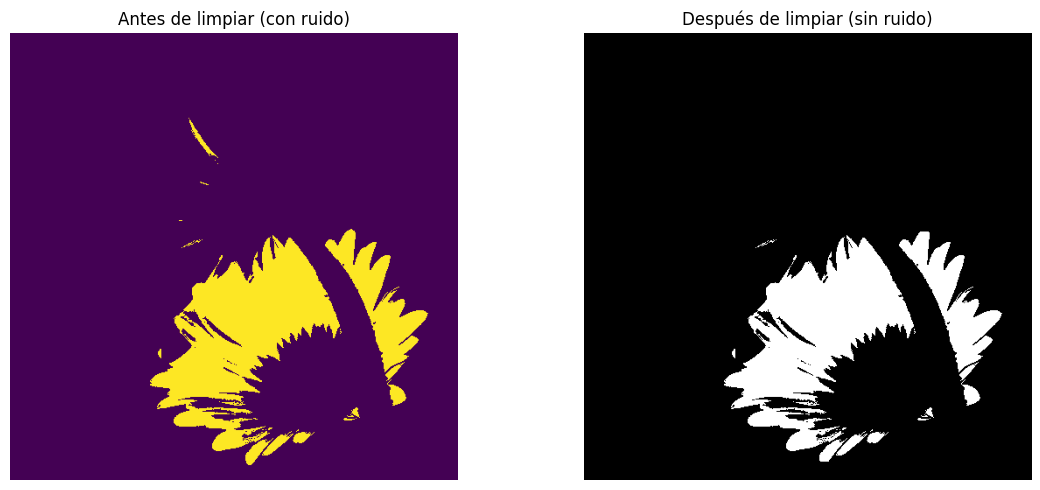

In [ ]:
# Eliminamos píxeles aislados analizando filas
# Si una fila tiene muy pocos píxeles segmentados, probablemente sea ruido
mascara_limpia = mascara_final.copy()
altura, ancho = mascara_final.shape

# Umbral: si una fila tiene menos de 10 píxeles, se considera ruido
umbral_ruido = 10
filas_eliminadas = 0

for i in range(altura):
    # Contamos píxeles segmentados en esta fila
    pixeles_en_fila = np.sum(mascara_final[i, :])

    if pixeles_en_fila < umbral_ruido:
        mascara_limpia[i, :] = False  # Eliminamos toda la fila
        filas_eliminadas += 1

print(f"=== ELIMINACIÓN DE RUIDO ===")
print(f"Filas eliminadas por ruido: {filas_eliminadas}")
print(f"Píxeles antes de limpiar: {np.sum(mascara_final)}")
print(f"Píxeles después de limpiar: {np.sum(mascara_limpia)}")
print(f"Píxeles de ruido eliminados: {np.sum(mascara_final) - np.sum(mascara_limpia)}")

# Comparación visual
mostrar_imagenes_lado_a_lado(
    mascara_final,
    mascara_limpia,
    "Antes de limpiar (con ruido)",
    "Después de limpiar (sin ruido)"
)

## Sección 6: Análisis de Resultados y Aplicaciones

### Detección del Rectángulo Delimitador
Una vez segmentado el objeto, podemos encontrar sus límites espaciales:

=== RECTÁNGULO DELIMITADOR ===
Esquina superior izquierda: (228, 160)
Esquina inferior derecha: (490, 477)
Dimensiones del rectángulo: 262 x 317 píxeles
Área del rectángulo: 83054 píxeles


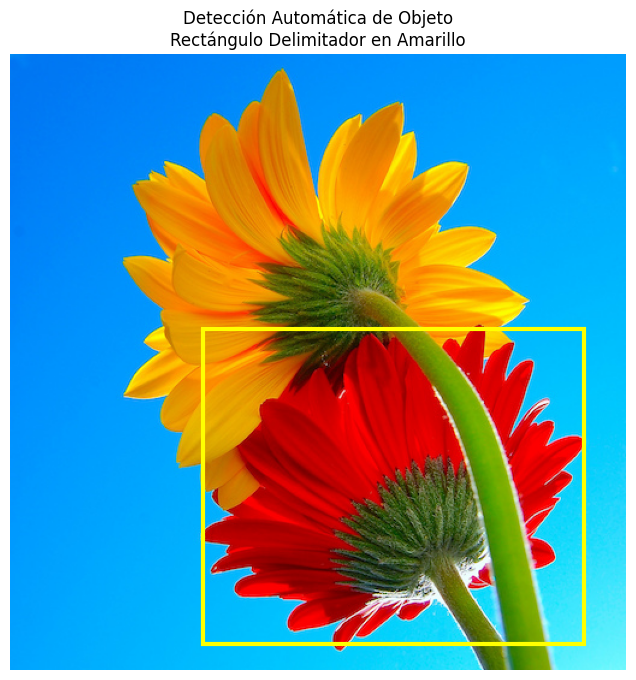

In [ ]:
# Encontramos las coordenadas extremas del objeto segmentado
# Buscamos píxeles activos (True) en la máscara limpia
coordenadas_activas = np.where(mascara_limpia)

if len(coordenadas_activas[0]) > 0:  # Si hay píxeles segmentados
    # Límites verticales (filas)
    fila_minima = np.min(coordenadas_activas[0])
    fila_maxima = np.max(coordenadas_activas[0])

    # Límites horizontales (columnas)
    columna_minima = np.min(coordenadas_activas[1])
    columna_maxima = np.max(coordenadas_activas[1])

    # Calculamos dimensiones del rectángulo
    alto_rectangulo = fila_maxima - fila_minima
    ancho_rectangulo = columna_maxima - columna_minima

    print("=== RECTÁNGULO DELIMITADOR ===")
    print(f"Esquina superior izquierda: ({fila_minima}, {columna_minima})")
    print(f"Esquina inferior derecha: ({fila_maxima}, {columna_maxima})")
    print(f"Dimensiones del rectángulo: {alto_rectangulo} x {ancho_rectangulo} píxeles")
    print(f"Área del rectángulo: {alto_rectangulo * ancho_rectangulo} píxeles")

    # Visualización del rectángulo sobre la imagen original
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.imshow(imagen_rgb)

    # Creamos y agregamos el rectángulo
    rectangulo = Rectangle(
        (columna_minima, fila_minima),  # (x, y) de la esquina inferior izquierda
        ancho_rectangulo,               # ancho
        alto_rectangulo,                # alto
        fill=False,                     # Solo el contorno
        edgecolor='yellow',             # Color amarillo para visibilidad
        linewidth=3                     # Línea gruesa
    )
    ax.add_patch(rectangulo)

    ax.set_title('Detección Automática de Objeto\nRectángulo Delimitador en Amarillo')
    ax.axis('off')
    plt.show()

else:
    print("No se encontraron píxeles segmentados para analizar.")

### Detección de Contornos (Alternativa Moderna)
Usando OpenCV podemos detectar contornos de manera más sofisticada:

=== DETECCIÓN DE CONTORNOS ===
Número de contornos encontrados: 28

Contorno 1:
  Área: 304 píxeles
  Perímetro: 101.1 píxeles

Contorno 2:
  Área: 156 píxeles
  Perímetro: 70.1 píxeles

Contorno 3:
  Área: 269 píxeles
  Perímetro: 110.9 píxeles

Contorno 4:
  Área: 0 píxeles
  Perímetro: 6.2 píxeles

Contorno 5:
  Área: 0 píxeles
  Perímetro: 0.0 píxeles

Contorno 6:
  Área: 0 píxeles
  Perímetro: 2.0 píxeles

Contorno 7:
  Área: 4 píxeles
  Perímetro: 10.2 píxeles

Contorno 8:
  Área: 0 píxeles
  Perímetro: 0.0 píxeles

Contorno 9:
  Área: 12 píxeles
  Perímetro: 25.7 píxeles

Contorno 10:
  Área: 1 píxeles
  Perímetro: 8.8 píxeles

Contorno 11:
  Área: 2 píxeles
  Perímetro: 18.5 píxeles

Contorno 12:
  Área: 42 píxeles
  Perímetro: 36.6 píxeles

Contorno 13:
  Área: 0 píxeles
  Perímetro: 0.0 píxeles

Contorno 14:
  Área: 278 píxeles
  Perímetro: 92.3 píxeles

Contorno 15:
  Área: 113 píxeles
  Perímetro: 65.7 píxeles

Contorno 16:
  Área: 20 píxeles
  Perímetro: 23.1 píxeles

Cont

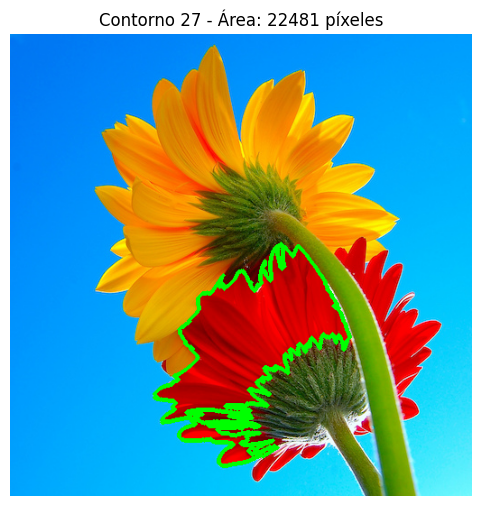


Contorno 28:
  Área: 5708 píxeles
  Perímetro: 768.6 píxeles


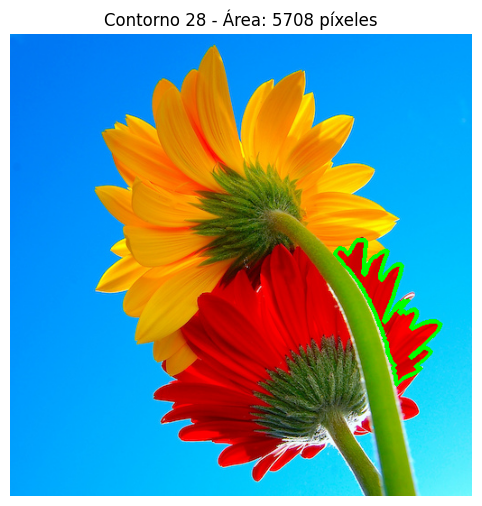


Los contornos nos permiten análisis más detallados de forma y geometría.


In [ ]:
# Convertimos la máscara a formato uint8 para OpenCV
mascara_uint8 = (mascara_limpia * 255).astype(np.uint8)

# Encontramos contornos usando OpenCV
contornos, jerarquia = findContours(
    mascara_uint8,
    RETR_EXTERNAL,      # Solo contornos externos
    CHAIN_APPROX_SIMPLE # Simplifica los contornos
)

print(f"=== DETECCIÓN DE CONTORNOS ===")
print(f"Número de contornos encontrados: {len(contornos)}")

# Analizamos cada contorno
for i, contorno in enumerate(contornos):
    # Calculamos el área del contorno
    import cv2
    area = cv2.contourArea(contorno)

    # Calculamos el perímetro
    perimetro = cv2.arcLength(contorno, True)

    print(f"\nContorno {i + 1}:")
    print(f"  Área: {area:.0f} píxeles")
    print(f"  Perímetro: {perimetro:.1f} píxeles")

    # Solo procesamos contornos grandes (evitamos ruido)
    if area > 1000:
        # Dibujamos el contorno sobre la imagen original
        imagen_con_contorno = imagen_rgb.copy()
        cv2.drawContours(imagen_con_contorno, [contorno], -1, (0, 255, 0), 3)

        plt.figure(figsize=(10, 6))
        plt.imshow(imagen_con_contorno)
        plt.title(f'Contorno {i + 1} - Área: {area:.0f} píxeles')
        plt.axis('off')
        plt.show()

print("\nLos contornos nos permiten análisis más detallados de forma y geometría.")

## Sección 7: Experimentos Interactivos y Extensiones

### Experimento: Probando Diferentes Umbrales
Veamos cómo diferentes umbrales afectan la segmentación:

=== EXPERIMENTANDO CON DIFERENTES UMBRALES ===
Observa cómo cambian los resultados:

1. Umbrales muy estrictos (pocos píxeles):


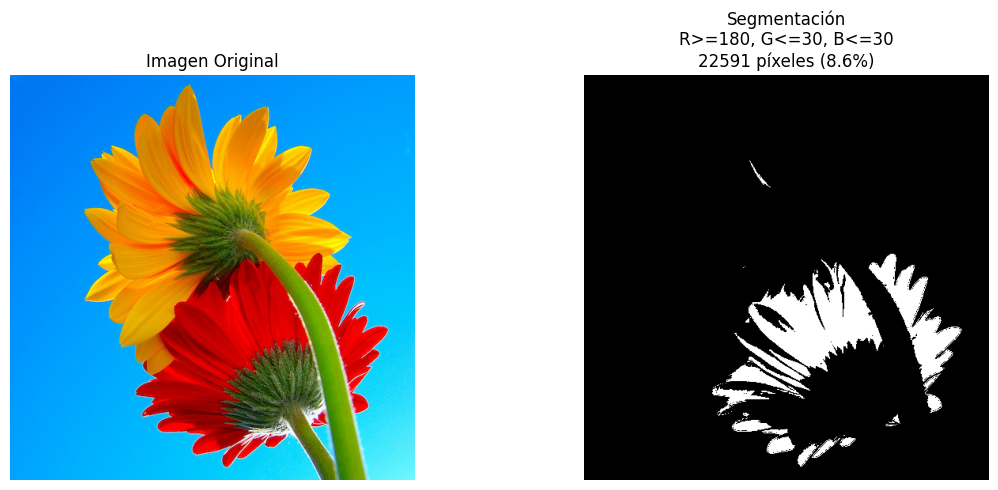


2. Umbrales muy relajados (muchos píxeles):


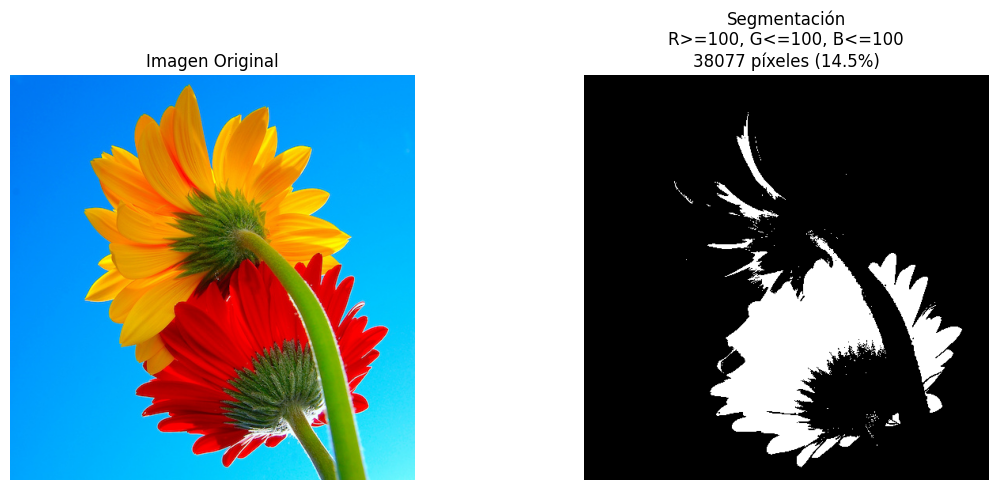


3. Umbrales balanceados (nuestros originales):


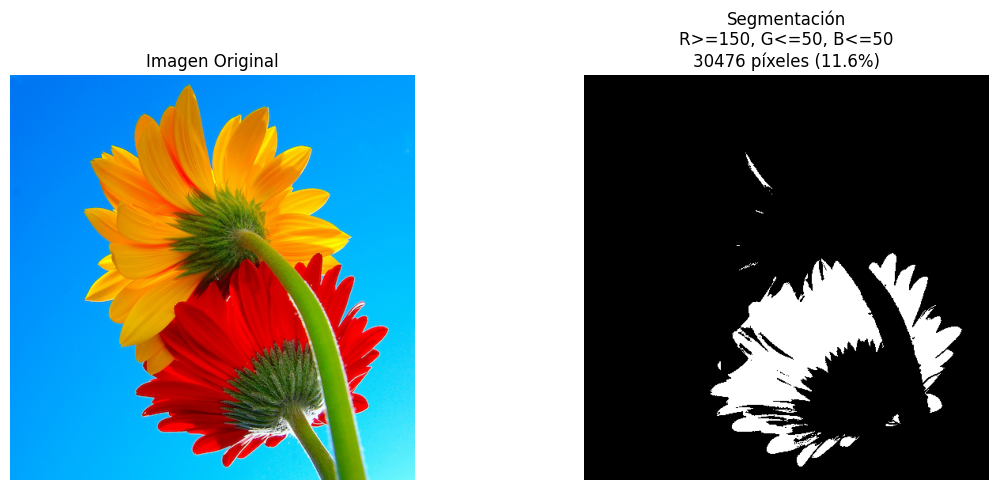

In [ ]:
def probar_umbrales(umbral_r_min, umbral_g_max, umbral_b_max):
    """
    Función para experimentar con diferentes umbrales de segmentación.
    """
    # Creamos nueva máscara con los umbrales dados
    nueva_mascara = (
        (canal_rojo >= umbral_r_min) &
        (canal_verde <= umbral_g_max) &
        (canal_azul <= umbral_b_max)
    )

    pixeles_segmentados = np.sum(nueva_mascara)
    porcentaje = 100 * pixeles_segmentados / nueva_mascara.size

    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].imshow(imagen_rgb)
    axes[0].set_title('Imagen Original')
    axes[0].axis('off')

    axes[1].imshow(nueva_mascara, cmap='gray')
    axes[1].set_title(f'Segmentación\nR>={umbral_r_min}, G<={umbral_g_max}, B<={umbral_b_max}\n{pixeles_segmentados} píxeles ({porcentaje:.1f}%)')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    return nueva_mascara

# Probamos diferentes combinaciones
print("=== EXPERIMENTANDO CON DIFERENTES UMBRALES ===")
print("Observa cómo cambian los resultados:")

print("\n1. Umbrales muy estrictos (pocos píxeles):")
mascara_estricta = probar_umbrales(180, 30, 30)

print("\n2. Umbrales muy relajados (muchos píxeles):")
mascara_relajada = probar_umbrales(100, 100, 100)

print("\n3. Umbrales balanceados (nuestros originales):")
mascara_balanceada = probar_umbrales(150, 50, 50)

### Widget Interactivo (Opcional)
Si el entorno lo permite, podemos crear controles interactivos:

In [ ]:
# Widget interactivo para experimentar con umbrales
# Nota: Esto funciona mejor en Jupyter notebooks locales
try:
    def segmentacion_interactiva(rojo_min=150, verde_max=50, azul_max=50):
        mascara = (
            (canal_rojo >= rojo_min) &
            (canal_verde <= verde_max) &
            (canal_azul <= azul_max)
        )

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        axes[0].imshow(imagen_rgb)
        axes[0].set_title('Original')
        axes[0].axis('off')

        axes[1].imshow(mascara, cmap='gray')
        axes[1].set_title(f'Segmentación: {np.sum(mascara)} píxeles')
        axes[1].axis('off')
        plt.show()

    # Creamos el widget interactivo
    interact(
        segmentacion_interactiva,
        rojo_min=IntSlider(min=0, max=255, step=5, value=150, description='Rojo mín:'),
        verde_max=IntSlider(min=0, max=255, step=5, value=50, description='Verde máx:'),
        azul_max=IntSlider(min=0, max=255, step=5, value=50, description='Azul máx:')
    )

except ImportError:
    print("Widget interactivo no disponible en este entorno.")
    print("Puedes experimentar manualmente cambiando los valores en la función probar_umbrales()")

interactive(children=(IntSlider(value=150, description='Rojo mín:', max=255, step=5), IntSlider(value=50, desc…

## Sección 8: Aplicaciones Prácticas y Extensiones

### Casos de Uso en el Mundo Real
La segmentación por color que acabamos de implementar tiene múltiples aplicaciones:

In [ ]:
# Ejemplo: Análisis de composición de colores en la imagen
def analizar_composicion_colores(imagen):
    """
    Analiza la composición de colores en una imagen.
    """
    altura, ancho, _ = imagen.shape
    total_pixeles = altura * ancho

    # Definimos rangos para diferentes colores
    colores_interes = {
        'Rojos': {'min': [150, 0, 0], 'max': [255, 50, 50]},
        'Verdes': {'min': [0, 150, 0], 'max': [50, 255, 50]},
        'Azules': {'min': [0, 0, 150], 'max': [50, 50, 255]},
        'Blancos/Claros': {'min': [200, 200, 200], 'max': [255, 255, 255]}
    }

    print("=== ANÁLISIS DE COMPOSICIÓN DE COLORES ===")
    print(f"Imagen analizada: {ancho} x {altura} píxeles ({total_pixeles} total)\n")

    resultados = {}

    for nombre_color, rangos in colores_interes.items():
        # Creamos máscara para este color
        limite_inf = np.array(rangos['min'])
        limite_sup = np.array(rangos['max'])

        mascara_color = inRange(imagen, limite_inf, limite_sup)
        pixeles_color = np.sum(mascara_color > 0)
        porcentaje = 100 * pixeles_color / total_pixeles

        resultados[nombre_color] = {
            'pixeles': pixeles_color,
            'porcentaje': porcentaje
        }

        print(f"{nombre_color:15}: {pixeles_color:8} píxeles ({porcentaje:5.2f}%)")

    return resultados

# Analizamos nuestra imagen
composicion = analizar_composicion_colores(imagen_rgb)

print("\n=== INTERPRETACIÓN ===")
print("Esta información podría usarse para:")
print("- Control de calidad en productos")
print("- Análisis automático de cultivos")
print("- Clasificación de imágenes médicas")
print("- Detección de objetos en tiempo real")

=== ANÁLISIS DE COMPOSICIÓN DE COLORES ===
Imagen analizada: 512 x 512 píxeles (262144 total)

Rojos          :    30476 píxeles (11.63%)
Verdes         :        0 píxeles ( 0.00%)
Azules         :        0 píxeles ( 0.00%)
Blancos/Claros :     1113 píxeles ( 0.42%)

=== INTERPRETACIÓN ===
Esta información podría usarse para:
- Control de calidad en productos
- Análisis automático de cultivos
- Clasificación de imágenes médicas
- Detección de objetos en tiempo real


## Sección 9: Reflexiones y Conexiones con Conceptos Anteriores

### ¿Cómo se conecta todo?
Este laboratorio integra conceptos fundamentales que hemos estudiado:

In [ ]:
# Demostración de cómo la cuantización afecta la segmentación
def demostrar_efecto_cuantizacion():
    """
    Muestra cómo la cuantización (reducción de bits) afecta la segmentación.
    """
    print("=== EFECTO DE LA CUANTIZACIÓN EN SEGMENTACIÓN ===")

    # Imagen original (8 bits por canal)
    segmentacion_8bits = probar_umbrales(150, 50, 50)
    pixeles_8bits = np.sum(segmentacion_8bits)

    # Simulamos cuantización a 4 bits (16 niveles por canal)
    imagen_4bits = (imagen_rgb // 16) * 16  # Reducimos resolución
    canal_r_4bits = imagen_4bits[:, :, 0]
    canal_g_4bits = imagen_4bits[:, :, 1]
    canal_b_4bits = imagen_4bits[:, :, 2]

    segmentacion_4bits = (
        (canal_r_4bits >= 144) &  # Ajustamos umbrales para cuantización
        (canal_g_4bits <= 48) &
        (canal_b_4bits <= 48)
    )
    pixeles_4bits = np.sum(segmentacion_4bits)

    # Comparación visual
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    axes[0, 0].imshow(imagen_rgb)
    axes[0, 0].set_title('Original (8 bits/canal)')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(segmentacion_8bits, cmap='gray')
    axes[0, 1].set_title(f'Segmentación 8 bits\n{pixeles_8bits} píxeles')
    axes[0, 1].axis('off')

    axes[1, 0].imshow(imagen_4bits)
    axes[1, 0].set_title('Cuantizada (4 bits/canal)')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(segmentacion_4bits, cmap='gray')
    axes[1, 1].set_title(f'Segmentación 4 bits\n{pixeles_4bits} píxeles')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"\nRESULTADOS:")
    print(f"Píxeles segmentados (8 bits): {pixeles_8bits}")
    print(f"Píxeles segmentados (4 bits): {pixeles_4bits}")
    print(f"Diferencia: {abs(pixeles_8bits - pixeles_4bits)} píxeles")
    print("\nCONCLUSIÓN: La cuantización afecta la precisión de la segmentación.")

demostrar_efecto_cuantizacion()

## Sección 10: Glosario y Conceptos Clave

### Glosario de Términos Técnicos

**GLOSARIO DE PROCESAMIENTO DE IMÁGENES**

**Segmentación**: Proceso de dividir una imagen en regiones significativas o objetos de interés.

**Máscara Binaria**: Imagen de dos valores (0 y 1, o False y True) que indica qué píxeles pertenecen a una región de interés.

**Umbral (Threshold)**: Valor que define el límite para clasificar píxeles. Por ejemplo, "rojo > 150".

**Espacio de Color**: Sistema para representar colores. RGB (Rojo-Verde-Azul) y BGR (Azul-Verde-Rojo) son ejemplos.

**Canal de Color**: Cada componente individual de un espacio de color (ej: canal R, G, o B en RGB).

**Histograma**: Gráfico que muestra la distribución de intensidades de píxeles en una imagen.

**Operación Lógica AND**: Operación que resulta True solo cuando TODAS las condiciones son True.

**Cuantización**: Proceso de reducir el número de niveles de intensidad en una imagen.

**Contorno**: Línea que define el borde o límite de un objeto en una imagen.

**Rectángulo Delimitador**: Rectángulo más pequeño que contiene completamente un objeto.

**Post-procesamiento**: Operaciones aplicadas después de la segmentación inicial para mejorar resultados.

**Ruido**: Píxeles o regiones pequeñas incorrectamente segmentadas, generalmente aisladas.

## Conclusiones y Próximos Pasos

### Lo que hemos aprendido:
1. **Integración de conceptos**: La segmentación usa espacios de color, cuantización y análisis estadístico
2. **Importancia de umbrales**: La elección correcta de umbrales es crucial para buenos resultados
3. **Post-procesamiento**: Los resultados iniciales siempre necesitan refinamiento
4. **Aplicaciones prácticas**: La segmentación es fundamental en múltiples industrias

### Conexiones con conceptos anteriores:
- **Espacios de color**: Essential para elegir el espacio más apropiado (RGB vs HSV)
- **Cuantización**: Afecta la precisión de la segmentación
- **Muestreo**: Determina la resolución espacial de nuestros resultados
- **Análisis estadístico**: Los histogramas guían la selección de umbrales

### Ejercicios para practicar:
1. Experimenta con diferentes imágenes y colores objetivo
2. Compara segmentación en RGB vs HSV
3. Implementa segmentación de múltiples colores simultáneamente
4. Investiga técnicas de segmentación más avanzadas

### Próximos temas sugeridos:
- Segmentación por textura
- Algoritmos de crecimiento de regiones
- Segmentación usando machine learning
- Análisis de forma y características geométricas